In [2]:
import pandas as pd
import numpy as np
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Set up paths
raw_folder = './raw_data/'
tmp_folder = './tmp_data/'
processed_folder = './processed_data/'

imdb_rating_folder = raw_folder + 'imdb/'
cmu_folder = raw_folder + 'CMU/'
baby_names_folder = raw_folder + 'baby_names_national/'

# Data preprocessing
In this notebook we aim to select the relevant features for our model and to clean the data. This also includes merging content from the different datasets, from various sources such as the `IMDB` datasets, the baby names datasets, etc... which have been either downloaded or scraped from the web.

**Note on structure:** We separate dataframes into various folders, raw, tmp (temporary data) and processed. 
- The raw data is what we download from the web, including the initial CMU datasets. These are unmodified content that we use as a basis for our work, it is read-only.
- The temporary (tmp) data is the data that we use to work on, and that we modify. This is often the case for scrapped data from the web, or dataframes that are being used in a different notebook other than processing.
- We put our final cleaned data in the processed folder, which is the data that we use for our models.

## 1. Initial view on the data
### a. CMU datasets
Our project requires the use of the `character.metadata.tsv` and `movie.metadata.tsv` files from the CMU databases.


In [7]:
# Import character metadata
character_df = pd.read_csv(cmu_folder + 'character.metadata.tsv', sep='\t', header=None)

# Add column names deduced from README
character_df.columns = ['wiki_ID', 'free_ID', 'release', 'char_name', 'DOB', 'gender', 'height', 'ethnicity', 'act_name', 'age_at_release', 'free_char_map1', 'free_char_map2', 'free_char_map3']

display(character_df.head())
print(f"There are {len(character_df)} characters in the dataset.")

,wiki_ID,free_ID,release,char_name,DOB,gender,height,ethnicity,act_name,age_at_release,free_char_map1,free_char_map2,free_char_map3
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


There are 450669 characters in the dataset.


In [8]:
# Import movie metadata
movie_df = pd.read_csv(cmu_folder + 'movie.metadata.tsv', sep='\t', header=None)

# Add column names deduced from README
movie_df.columns = ['wiki_ID', 'free_ID', 'mov_name', 'release', 'revenue', 'runtime', 'languages', 'countries', 'genres']
display(movie_df.head(5))
print(f"There are {len(movie_df)} movies in the dataset.")
print(f"Is the wiki_ID unique? {movie_df.wiki_ID.is_unique}")

,wiki_ID,free_ID,mov_name,release,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


There are 81741 movies in the dataset.
Is the wiki_ID unique? True


Great, we can use the wikipedia IDs as unique identifers for the movies!

We immediately see that there are some columns that we won't need in our analysis, which we will drop later on, such as the freebase character maps, releases in the characters dataframe (because they are already in the movies dataframe), etc...

We also see that there are some missing values for `revenues`, we need to take note of how any of them are missing to see if they would affect our analysis.

In [9]:
nb_revenue_missing = movie_df['revenue'].isna().sum()
total_movies = len(movie_df)
perc_missing = (nb_revenue_missing / total_movies)*100
print(f"Percentage of missing values in column 'revenue': {perc_missing:.2f}%")

Percentage of missing values in column 'revenue': 89.72%


### b. IMDB datasets: Ratings
We would like to use ratings and rating counts to assess the popularity of a movie. We will use the `imdb_ratings.tsv` file from the [IMDB datasets](https://datasets.imdbws.com/).

In [10]:
# Import imdb data
rating_df = pd.read_csv(imdb_rating_folder + 'imdb_rating.tsv', sep='\t', index_col='tconst')
display(rating_df.head())

,averageRating,numVotes
tconst,,
tt0000001,5.7,2004
tt0000002,5.8,269
tt0000003,6.5,1904
tt0000004,5.5,178
tt0000005,6.2,2685


In [11]:
# Verify the indexes are unique
print(f"Is the indexing unique ? {rating_df.index.is_unique}")

Is the indexing unique ? True


`tconst` is a unique identifer in the IMDB database, which we can use to merge with our other dataframes. We need to figure out how to merge these dataframes together.

### c. Baby names data
We consider the names of babies across the years in the USA to be a good indicator of the popularity of a name. We will use the `NationalNames.csv` file from the [US Social Security Administration](https://www.ssa.gov/oact/babynames/limits.html), and will be put in the `baby_names_national` folder. This dataset has all the names of babies born in the USA from 1880 to 2023, where each count is the number of babies born with that name in that year.

We need to iterate over all the years to create a dataframe with the counts of all the names, for all years:
- `name`: name of the baby
- `year`: year of birth
- `number`: number of babies born with that name in that year 
- `percentage`: percentage of babies born with that name in that year, for normalization purposes (added later in the notebook)

In [12]:
# Define the path to your dataset folder
folder_path = 'raw_data/baby_names_national/'

# Create an empty list to store individual DataFrames
data_frames = []

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    if filename.startswith('yob') and filename.endswith('.txt'):
        # Extract the year from the filename
        year = int(filename[3:-4])

        # Read the data from the file into a DataFrame
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, header=None, names=['name', 'gender', 'number'])

        # Add the 'year' column to the DataFrame
        df['year'] = year

        # Append the current DataFrame to the list
        data_frames.append(df)

# Concatenate all DataFrames in the list into one DataFrame
baby_name_df = pd.concat(data_frames, ignore_index=True)

# Set the 'name' column as the index
# combined_data.set_index('name', inplace=True)

# Display the resulting DataFrame
baby_name_df.head()

,name,gender,number,year
0,Mary,F,64388,1953
1,Linda,F,61281,1953
2,Deborah,F,52196,1953
3,Patricia,F,51021,1953
4,Susan,F,44295,1953


## 2. Data processing and cleaning
In this section we modify some of the dataframes values to make them usable for our analysis, and populate them with extra data from other sources.

### a. Linking external movie IDs (Scraping part 1)
One of our main sources of data is the [IMDB](https://www.imdb.com/) and the [TMDB](https://www.themoviedb.org/) website. To be able to do so, we need to find a link from our CMU IDs (wikipedia) to the IMDB and TMDB movie IDs. We've explored 2 methods of collecting this kind of data. All the process is extensively documented in the `convert_ds.ipynb` notebook. 

Therefore make sure you run [this notebook](./scraping/convert_ids.ipynb) before continuing. It should have generated the `movies_external_ids.csv` file in the `tmp` folder, which we will use in the following steps.

In [13]:
# Test import with a try
try:
    df = pd.read_csv(tmp_folder + 'movies_external_ids.csv', sep='\t', header=None)
except:
    raise FileNotFoundError("Please run the ID scrapping notebook first.")

### b. Movie metadata preprocessing
#### Release date column
The release date column is very important for our study. Let's compute the missing values and remove the NaN value in the release column, we will drop these rows later on.

In [14]:
nb_release_missing = movie_df['release'].isna().sum()
total_movies = len(movie_df)
perc_missing = (nb_release_missing / total_movies)*100
print(f"Percentage of missing values in column 'release': {perc_missing:.2f}%")

Percentage of missing values in column 'release': 8.44%


. The movies release has a weird format. There are 3 different formats:
- of length 10: `YYYY-MM-DD`
- of length 7: `YYYY-MM`
- of length 4: `YYYY`

In [16]:
counts_lengths = movie_df['release'].dropna().apply(lambda x: len(str(x))).value_counts()
print(f"In the release column of movie_df the string have the following lengths with their frequency : \n\n{counts_lengths}")

In the release column of movie_df the string have the following lengths with their frequency : 

release
10    39373
4     32172
7      3294
Name: count, dtype: int64


In [22]:
length4_test = movie_df[movie_df['release'].apply(lambda x: len(str(x)) == 4)].iloc[0]['release']
print(f"Example of a value of length 4: {length4_test}")
length7_test = movie_df[movie_df['release'].apply(lambda x: len(str(x)) == 7)].iloc[0]['release']
print(f"Example of a value of length 7: {length7_test}")
length10_test = movie_df[movie_df['release'].apply(lambda x: len(str(x)) == 10)].iloc[0]['release']
print(f"Example of a value of length 10: {length10_test}")

Example of a value of length 4: 1988
Example of a value of length 7: 2003-10
Example of a value of length 10: 2001-08-24


We should convert the release date to keep only the year as we have only the year in the baby name dataset. To do so we simply take the first 4 characters of the release date, which is the year. We then convert it to an integer.

In [89]:
# Drop rows with NaN values in the release column
movie_datetime_df = movie_df.dropna(subset=['release']).copy(deep=True)

# Separate year, month and date
dates = movie_datetime_df.release
movie_datetime_df['year'] = dates.apply(lambda x: x if x is np.NaN else int(str(x)[:4])).astype(pd.Int64Dtype())
movie_datetime_df['month'] = dates.apply(lambda x: x if x is np.NaN else int(str(x)[5:7]) if len(x) > 4 else np.NaN).astype(pd.Int64Dtype())
movie_datetime_df['day'] = dates.apply(lambda x: x if x is np.NaN else int(str(x)[8:]) if len(x) > 7 else np.NaN).astype(pd.Int64Dtype())

# Remove outliers (years before 1800, there is one that is at 1010)
movie_datetime_df = movie_datetime_df[movie_datetime_df['year'] >= 1800]

movie_datetime_df[['wiki_ID', 'mov_name', 'year', 'month', 'day', 'release']].head()

,wiki_ID,mov_name,year,month,day,release
0,975900,Ghosts of Mars,2001,8,24,2001-08-24
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,2,16,2000-02-16
2,28463795,Brun bitter,1988,<NA>,<NA>,1988
3,9363483,White Of The Eye,1987,<NA>,<NA>,1987
4,261236,A Woman in Flames,1983,<NA>,<NA>,1983


In [90]:
# Reset the movie_df to the datetime version
movie_df = movie_datetime_df.copy(deep=True)

#### Add movie ratings and count

In [91]:
# Import idmb with wikidata index mapping
movies_to_imdb_id_df = pd.read_csv(tmp_folder + 'movies_external_ids.csv')
display(movies_to_imdb_id_df)

,wikipedia_ID,IMDB_ID,TMDB_ID
0,22760465,ch0112831,NaN
1,185519,nm0158560,NaN
2,12754957,nm0704910,NaN
3,10111255,nm1016169,NaN
4,7669437,tt0000001,16612.0
...,...,...,...
76650,22780907,tt9834564,834616.0
76651,7316179,tt9855214,279530.0
76652,17475562,tt9881364,1181096.0
76653,8783319,tt9898504,NaN


Let's check if we have the rating of all the movies. To do so we carry out a left merge and count the number of missing values:

In [92]:
left_merged_imdb_movie_df = pd.merge(movie_df.reset_index(), movies_to_imdb_id_df, left_on='wiki_ID', right_on='wikipedia_ID', how='left').copy(deep=True)
display(left_merged_imdb_movie_df.head(2))
print(f"Length of the dataframe : {len(left_merged_imdb_movie_df)}")

,index,wiki_ID,free_ID,mov_name,release,revenue,runtime,languages,countries,genres,year,month,day,wikipedia_ID,IMDB_ID,TMDB_ID
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,975900.0,tt0228333,10016.0
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,3196793.0,tt0245916,784579.0


Length of the dataframe : 74838


In [93]:
nb_rating_missing = left_merged_imdb_movie_df['IMDB_ID'].isna().sum()
total_movies = len(left_merged_imdb_movie_df)
perc_missing = (nb_rating_missing / total_movies)*100
print(f"Percentage of missing values in column 'averageRating': {perc_missing:.2f}%")

Percentage of missing values in column 'averageRating': 5.04%


We miss about 5% of the IMDB index. Therefore, the number of movie is reduced of 5% as well. Let's make the inner merge to keep only the movie for which we know the rating

In [94]:
merged_imdb_movie_df = pd.merge(movie_df.reset_index(), movies_to_imdb_id_df, left_on='wiki_ID', right_on='wikipedia_ID', how='inner').copy(deep=True)
display(merged_imdb_movie_df.head(2))
print(f"Length of the dataframe : {len(merged_imdb_movie_df)}")

merged_rating_movie_df = pd.merge(merged_imdb_movie_df, rating_df, left_on='IMDB_ID', right_on='tconst', how='inner').copy(deep=True)
display(merged_rating_movie_df.head(2))
print(f"Length of the dataframe : {len(merged_rating_movie_df)}")

,index,wiki_ID,free_ID,mov_name,release,revenue,runtime,languages,countries,genres,year,month,day,wikipedia_ID,IMDB_ID,TMDB_ID
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,975900,tt0228333,10016.0
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,3196793,tt0245916,784579.0


Length of the dataframe : 71064


,index,wiki_ID,free_ID,mov_name,release,revenue,runtime,languages,countries,genres,year,month,day,wikipedia_ID,IMDB_ID,TMDB_ID,averageRating,numVotes
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,975900,tt0228333,10016.0,4.9,56880
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,3196793,tt0245916,784579.0,6.0,69


Length of the dataframe : 65503


Lets remove the columns that we don't need

In [95]:
movie_rating_df = merged_rating_movie_df[['wiki_ID', 'mov_name', 'year', 'month', 'revenue', 'genres', 'numVotes', 'averageRating']].copy(deep=True)
display(movie_rating_df.head(2))
print(f"length of the dataframe : {len(movie_rating_df)}")

,wiki_ID,mov_name,year,month,revenue,genres,numVotes,averageRating
0,975900,Ghosts of Mars,2001,8,14010832.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",56880,4.9
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,2,NaN,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",69,6.0


length of the dataframe : 65503


In [96]:
movie_df = movie_rating_df.copy(deep=True)

### Genre column cleaning

In [97]:
print(f"Are there movies with missing genre fields? {movie_df['genres'].isna().sum() != 0}")

Are there movies with missing genre fields? False


In the genre column we have dictionaries. The key is a freebase value, and the value is the associated string. So we'll keep the string only, and we'll end up with a simple list of genres.

We want to generate an aditional dataset that has the wikiID of a movie and the genre asosciated with that movie.

In [98]:
def genres_convert(genres_raw):
    """Converts the genres column from a string to a list of genres
    """
    genres_list = []
    genres_raw = json.loads(genres_raw)

    # Keep only values
    for genre in genres_raw.values():
        genres_list.append(genre)

    return genres_list

In [99]:
# Transform genres column from json string to list
movies_processed_genres = movie_df.copy(deep=True)
movies_processed_genres['genres'] = movies_processed_genres['genres'].apply(genres_convert)

# Create a new DataFrame with each genre in a separate row
expanded_genres = pd.DataFrame(columns=['wiki_ID', 'genre'])

# We don't directly add rows to the DataFrame because it is inefficient, so we create lists to store the values
exp_wiki_ids = []
exp_genres = []
for index, row in movies_processed_genres.iterrows():
    # Extract wikiID and genres dictionary
    wiki_id = row['wiki_ID']
    genre_list = row['genres']

    # Iterate through each genre in the genres dictionary
    for genre in genre_list:
        # Append each genre as a new row to the expanded_genres DataFrame
        exp_wiki_ids += [wiki_id]
        exp_genres += [genre]

expanded_genres['wiki_ID'] = exp_wiki_ids
expanded_genres['genre'] = exp_genres

# Set index to wikiID
expanded_genres.set_index('wiki_ID', inplace=True)
expanded_genres.sort_index(inplace=True)
expanded_genres.groupby('genre').count().sort_values(by='genre', ascending=False)

print(f"Number of different genres: {len(expanded_genres['genre'].unique())}")

display(expanded_genres.head())
print(f"Length of the genres dataframe : {len(expanded_genres)}")

Number of different genres: 363


,genre
wiki_ID,
330,Comedy-drama
330,Drama
3217,Action
3217,Comedy
3217,Time travel


Length of the genres dataframe : 213854


In [100]:
# Save the processed dataframe
expanded_genres.to_csv(processed_folder + 'movie_genres_df.csv')

# Remove the genres column from the movie_df
movie_df.drop(columns=['genres'], inplace=True)
display(movie_df.head(2))

,wiki_ID,mov_name,year,month,revenue,numVotes,averageRating
0,975900,Ghosts of Mars,2001,8,14010832.0,56880,4.9
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,2,NaN,69,6.0


Let's do a simple data exploration on the genres of the movies:

/home/link/miniconda3/envs/ada/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/link/miniconda3/envs/ada/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


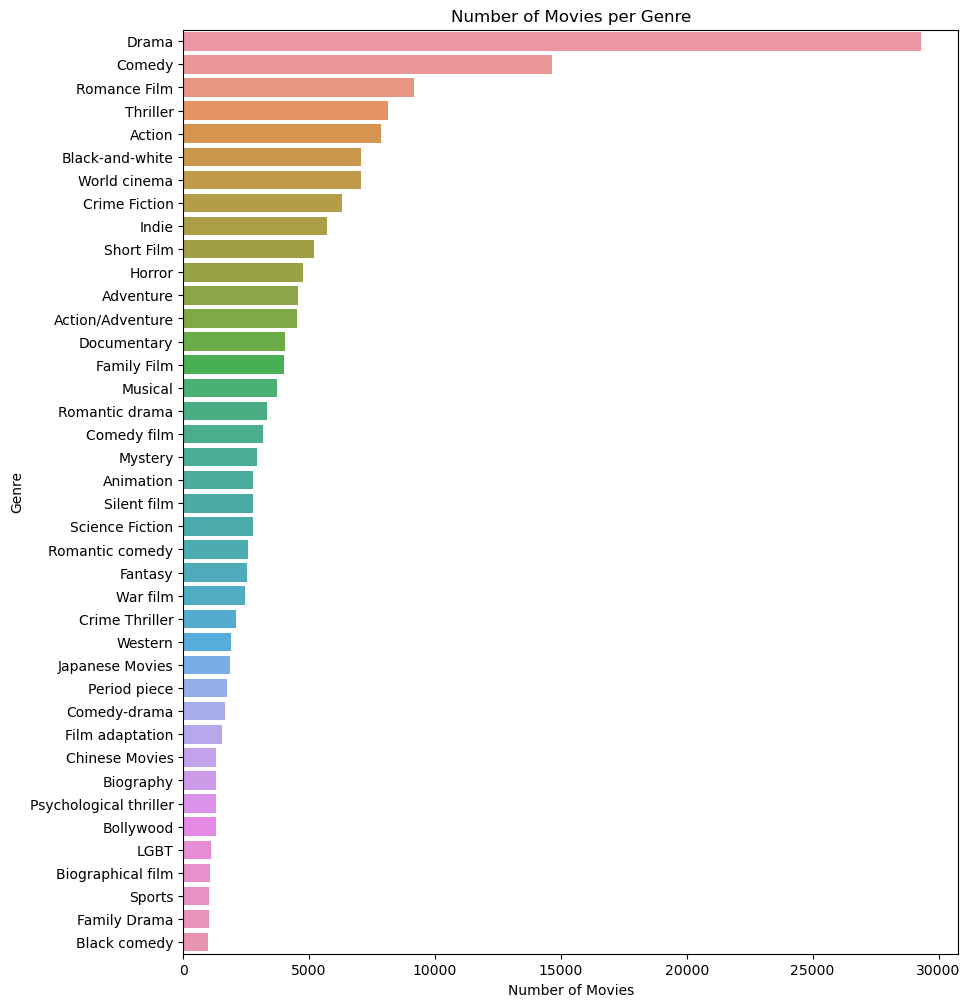

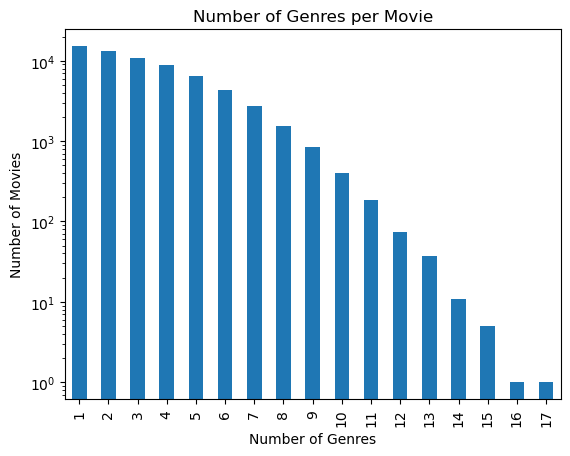

In [101]:
# Plot the number of movies per genre
plt.figure(figsize=(10, 12))
sns.countplot(y='genre', data=expanded_genres, order=expanded_genres['genre'].value_counts().index[:40]) # only take top 40 genres

plt.title('Number of Movies per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

# Count the number of genres in movies
genre_counts = expanded_genres.groupby('wiki_ID')['genre'].count()
genre_count_frequency = genre_counts.value_counts().sort_index()

genre_count_frequency.plot(kind='bar')
plt.title('Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Number of Movies')
plt.yscale('log')
plt.show()

### c. Baby name data preprocessing
First we combine the rows with the same name and same year in order to ignore the gender in the dataset: we study the overall impact of the name regardless of the gender of the baby

In [102]:
baby_name_filtered_df = baby_name_df.groupby(['name', 'year'])['number'].sum().to_frame()
display(baby_name_filtered_df)

number
name    year        
Aaban   2007       5
        2009       6
        2010       9
        2011      11
        2012      11
...              ...
Zyvon   2015       7
Zyyanna 2010       6
Zyyon   2014       6
Zzyzx   2010       5
        2018       5

[1903290 rows x 1 columns]

For each datapoint, compute the percentage of the total births in the year. We do this to normalize the data, in case the number of births per year has increased over the years or if a year had notably more births than another.

In [103]:
# group the baby name dataframe by year to get the number of birth per year.
birth_per_year_df = baby_name_filtered_df.groupby('year')['number'].sum().to_frame()
birth_per_year_df.reset_index(inplace=True)

birth_per_year_df = birth_per_year_df.rename(columns={'number': 'total_number'})

print("birth_per_year_df:")
display(birth_per_year_df.head(3))

# Merge dataframes
merged_df = pd.merge(baby_name_filtered_df.reset_index(), birth_per_year_df, on='year')

# Calculate the percentage and add it as a new column to dataframe
merged_df['percentage'] = (merged_df['number'] / merged_df['total_number']) * 100

print("merged_df:")
display(merged_df.head(3))

baby_name_with_percentage_df = merged_df.drop('total_number', axis=1)
baby_name_with_percentage_df.set_index(['name', 'year'], inplace=True)

print("baby_name_with_percentage_df:")
display(baby_name_with_percentage_df.head(3))

birth_per_year_df:


,year,total_number
0,1880,201484
1,1881,192690
2,1882,221533


merged_df:


,name,year,number,total_number,percentage
0,Aaban,2007,5,3996648,0.000125
1,Aadam,2007,8,3996648,0.000200
2,Aadan,2007,8,3996648,0.000200


baby_name_with_percentage_df:


,,number,percentage
name,year,,
Aaban,2007,5,0.000125
Aadam,2007,8,0.000200
Aadan,2007,8,0.000200


### d. Character metadata preprocessing
The character dataframe has not a unique index. It is due to the several NaN values present in the same movie. To tackles this we can drop the rows that have a NaN as name and see if it solve the issue.

In [104]:
character_filtered = character_df.copy(deep=True)

# Drop the rows with a NaN as the character name
character_filtered = character_filtered.dropna(subset=['char_name'])

# Drop the rows with the same character name
character_filtered = character_filtered.drop_duplicates(subset=['wiki_ID','char_name','gender'])
character_filtered = character_filtered.set_index(['wiki_ID','char_name', 'gender'])

display(character_filtered.head())

free_ID     release         DOB  \
wiki_ID char_name                  gender                                      
975900  Akooshay                   F       /m/03vyhn  2001-08-24  1958-08-26   
        Lieutenant Melanie Ballard F       /m/03vyhn  2001-08-24  1974-08-15   
        Desolation Williams        M       /m/03vyhn  2001-08-24  1969-06-15   
        Sgt Jericho Butler         M       /m/03vyhn  2001-08-24  1967-09-12   
        Bashira Kincaid            F       /m/03vyhn  2001-08-24  1977-09-25   

                                           height   ethnicity  \
wiki_ID char_name                  gender                       
975900  Akooshay                   F        1.620         NaN   
        Lieutenant Melanie Ballard F        1.780  /m/044038p   
        Desolation Williams        M        1.727     /m/0x67   
        Sgt Jericho Butler         M        1.750         NaN   
        Bashira Kincaid            F        1.650         NaN   

                                                     act_name  age_at_release  \
wiki_ID char_name                  gender                                       
975900  Akooshay                   F           Wanda De Jesus            42.0   
        Lieutenant Melanie Ballard F       Natasha Henstridge            27.0   
        Desolation Williams        M                 Ice Cube            32.0   
        Sgt Jericho Butler         M            Jason Statham            33.0   
        Bashira Kincaid            F              Clea DuVall            23.0   

                                          free_char_map1 free_char_map2  \
wiki_ID char_name                  gender                                 
975900  Akooshay                   F          /m/0bgchxw     /m/0bgcj3x   
        Lieutenant Melanie Ballard F           /m/0jys3m     /m/0bgchn4   
        Desolation Williams        M           /m/0jys3g     /m/0bgchn_   
        Sgt Jericho Butler         M          /m/02vchl6     /m/0bgchnq   
        Bashira Kincaid            F          /m/02vbb3r     /m/0bgchp9   

                                          free_char_map3  
wiki_ID char_name                  gender                 
975900  Akooshay                   F          /m/03wcfv7  
        Lieutenant Melanie Ballard F           /m/0346l4  
        Desolation Williams        M          /m/01vw26l  
        Sgt Jericho Butler         M           /m/034hyc  
        Bashira Kincaid            F           /m/01y9xg

We drop all columns that are not interesting for us:

In [105]:
columns_to_drop = ['free_ID', 'release', 'ethnicity', 'free_char_map1', 'free_char_map2', 'free_char_map3']
columns_to_drop_existing = [col for col in columns_to_drop if col in character_filtered.columns]

character_filtered.drop(columns_to_drop_existing, axis=1, inplace=True)

display(character_filtered.head())

print(f"Length of the dataframe: {len(character_filtered)}")

# Verify the indexes are unique
print(f"Is the indexing unique ? {character_filtered.index.is_unique}")

DOB  height  \
wiki_ID char_name                  gender                       
975900  Akooshay                   F       1958-08-26   1.620   
        Lieutenant Melanie Ballard F       1974-08-15   1.780   
        Desolation Williams        M       1969-06-15   1.727   
        Sgt Jericho Butler         M       1967-09-12   1.750   
        Bashira Kincaid            F       1977-09-25   1.650   

                                                     act_name  age_at_release  
wiki_ID char_name                  gender                                      
975900  Akooshay                   F           Wanda De Jesus            42.0  
        Lieutenant Melanie Ballard F       Natasha Henstridge            27.0  
        Desolation Williams        M                 Ice Cube            32.0  
        Sgt Jericho Butler         M            Jason Statham            33.0  
        Bashira Kincaid            F              Clea DuVall            23.0

Length of the dataframe: 189784
Is the indexing unique ? True


To optimize, we remove all the characters that are not in the movies dataframe (since we cleaned that):

In [100]:
# Grab all the movie IDs
movie_ids = movie_df['wiki_ID'].copy(deep=True)

# Merge the two dataframes
dump_characters = character_filtered.reset_index().set_index('wiki_ID')
character_filtered = dump_characters.merge(movie_ids, on='wiki_ID', how='inner')

# Reset the index to before
character_filtered = character_filtered.set_index(['wiki_ID', 'char_name', 'gender'])

print(f"Length of the dataframe: {len(character_filtered)}")
print(f"Is the indexing unique ? {character_filtered.index.is_unique}")

Length of the dataframe: 181267
Is the indexing unique ? True


We now create a dataframe with the name of the characetrs and the wikiID of the movie, and their genders, called `name_by_movie_df.csv`

In [106]:
name_df = character_filtered.reset_index()[['wiki_ID', 'char_name', 'gender']].copy(deep=True)
display(name_df.head())

,wiki_ID,char_name,gender
0,975900,Akooshay,F
1,975900,Lieutenant Melanie Ballard,F
2,975900,Desolation Williams,M
3,975900,Sgt Jericho Butler,M
4,975900,Bashira Kincaid,F


Let's split the character names and explode it:

In [107]:
# Split the character names into words and explode the lists
exploded_name_df = name_df.assign(char_words=name_df['char_name'].str.split()).explode('char_words')
word_name_df = exploded_name_df.drop(columns=['char_name'])
display(word_name_df.head())

,wiki_ID,gender,char_words
0,975900,F,Akooshay
1,975900,F,Lieutenant
1,975900,F,Melanie
1,975900,F,Ballard
2,975900,M,Desolation


Now we take care of duplicates for both the characters dataframe (repeated names) and the baby names (keep only one per year), so that we can merge them without any issues.

In [108]:
# Drop the rows with the same character name
print(f"Size before duplicates removal: {len(word_name_df)}")
word_name_df = word_name_df.drop_duplicates(subset=['wiki_ID', 'gender', 'char_words'])
print(f"Size after duplicates removal: {len(word_name_df)}")

Size before duplicates removal: 319539
Size after duplicates removal: 302423


In [109]:
baby_name_only_df = baby_name_df[['name']].copy(deep=True)

# Does the baby_name_only_df has duplicates?
duplicates = baby_name_only_df.duplicated()
print(f"number of duplicates in baby_name_only_df = {duplicates.sum()}")

# Drop these duplicates
baby_name_only_df = baby_name_only_df.drop_duplicates()
duplicates = baby_name_only_df.duplicated()
print(f"number of duplicates in baby_name_only_df = {duplicates.sum()}")

display(baby_name_only_df.head())

number of duplicates in baby_name_only_df = 1982709
number of duplicates in baby_name_only_df = 0


,name
0,Mary
1,Linda
2,Deborah
3,Patricia
4,Susan


Filter the names to keep only the ones available in the baby name dataset

In [110]:
# Use pd.merge to filter rows based on 'names' column
word_name_filtered_df = pd.merge(word_name_df.reset_index(), baby_name_only_df, left_on='char_words', right_on='name', how='inner')

word_name_filtered_df.drop(columns=['index', 'name'], inplace=True)
word_name_filtered_df.set_index(['wiki_ID', 'char_words', 'gender'], inplace=True)
print("word_name_filtered_df :")
display(word_name_filtered_df.head())

# Verify the indexes are unique
print(f"Is the indexing unique ? {word_name_filtered_df.index.is_unique}")

word_name_filtered_df :


,,
wiki_ID,char_words,gender
975900,Lieutenant,F
7668793,Lieutenant,M
24226493,Lieutenant,M
3388805,Lieutenant,M
8231713,Lieutenant,M


Is the indexing unique ? True


In [111]:
# check for the first movie of the CMU dataset, seems ok
word_name_filtered_df.loc[975900]

,
char_words,gender
Lieutenant,F
Melanie,F
Ballard,F
Williams,M
Jericho,M
Butler,M
Bashira,F
Kincaid,F
Helena,F


The name Lieutenant is still in the filtered baby names dataframe. Let's check if this name is in the baby name dataset

In [112]:
name_to_search = 'Lieutenant'

# Check if the name is present
is_name_present = name_to_search in baby_name_only_df['name'].values

if is_name_present:
    print(f"{name_to_search} is present in the DataFrame.")
else:
    print(f"{name_to_search} is not present in the DataFrame.")

Lieutenant is present in the DataFrame.


We save this dataframe in `tmp` so that we can access this data in the next scraping part:

In [113]:
word_name_filtered_df.reset_index().to_csv(os.path.join(tmp_folder, 'name_by_movie_df.csv'), index=False)

### f. Adding order to the characters in a movie (Scraping part 2)
The website [TMDB claims that](https://www.themoviedb.org/bible/movie/59f3b16d9251414f20000003#59f73ca49251416e7100000e) roles for characters are ordered by importance, namely that major roles are always credited before small parts. 

Therefore make sure you run [this notebook](./scraping/order_characters.ipynb) before continuing. It should have updated the `name_by_movie_ordered_df.csv` file in the `processed` folder, which we will use for our data analysis journey.

## 3. Exporting the remaining dataframes
We save the files that we will use for our data analysis journey:

In [114]:
display(movie_df.head())
# Export DataFrame to a CSV file in the processed data folder
movie_df.to_csv(os.path.join(processed_folder, 'movie_df.csv'), index=False)

,wiki_ID,mov_name,year,month,revenue,numVotes,averageRating
0,975900,Ghosts of Mars,2001,8,14010832.0,56880,4.9
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,2,NaN,69,6.0
2,28463795,Brun bitter,1988,<NA>,NaN,40,5.6
3,9363483,White Of The Eye,1987,<NA>,NaN,2891,6.1
4,261236,A Woman in Flames,1983,<NA>,NaN,623,5.9


In [120]:
display(baby_name_with_percentage_df.reset_index().head())
# Export DataFrame to a CSV file in the processed data folder
baby_name_with_percentage_df.reset_index().to_csv(os.path.join(processed_folder, 'baby_name_df.csv'), index=False)

,name,year,number,percentage
0,Aaban,2007,5,0.000125
1,Aadam,2007,8,0.000200
2,Aadan,2007,8,0.000200
3,Aadarsh,2007,13,0.000325
4,Aaden,2007,157,0.003928


We're done with the basic preprocessing! Now we move onto the regression analysis